In [ ]:
%pip install pandas
%pip install matplotlib
%pip install seaborn as sns
%pip install scikit-learn


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
import numpy as np



In [5]:
stock_file_path = './all_stock_and_etfs.csv'  

In [6]:
stock_df = pd.read_csv(stock_file_path)
stock_df

,Date-Time,Open,High,Low,Close,Volume,Ticker_Symbol
0,2024-02-20,29.09,29.7100,29.0001,29.44,2673889,HRL
1,2024-02-16,29.01,29.1700,28.7650,28.99,5655091,HRL
2,2024-02-15,28.94,29.2210,28.8500,29.11,2380372,HRL
3,2024-02-14,28.76,28.8254,28.5100,28.80,2690379,HRL
4,2024-02-13,29.56,29.8000,28.6350,28.72,4173650,HRL
...,...,...,...,...,...,...,...
163552,1999-11-05,9.25,9.5000,9.2500,9.50,2300,ALG
163553,1999-11-04,9.31,9.4400,9.3100,9.31,1100,ALG
163554,1999-11-03,9.00,9.2500,9.0000,9.19,35000,ALG
163555,1999-11-02,8.75,8.8800,8.6200,8.88,7700,ALG


## Generate Monthly ETF Values

In [7]:
stock_df['Date-Time'] = pd.to_datetime(stock_df['Date-Time'])

stock_df['Year'] = stock_df['Date-Time'].dt.year
stock_df['Month'] = stock_df['Date-Time'].dt.month

data_grouped = stock_df.groupby(['Year', 'Month', 'Ticker_Symbol']).agg({
    'Close': 'mean'
}).reset_index()

data_grouped.columns = ['Year', 'Month', 'Ticker_Symbol', 'Average_Close']
data_grouped

,Year,Month,Ticker_Symbol,Average_Close
0,1999,11,ADM,12.525238
1,1999,11,AGCO,11.762381
2,1999,11,ALG,9.661429
3,1999,11,CAG,24.602857
4,1999,11,CAT,52.900000
...,...,...,...,...
7809,2024,2,TSN,54.019231
7810,2024,2,VMI,231.409231
7811,2024,2,VOO,457.941250
7812,2024,2,WEN,18.983077


## VWAP 

In [8]:
stock_df['Date-Time'] = pd.to_datetime(stock_df['Date-Time'])
stock_df['Year'] = stock_df['Date-Time'].dt.year
stock_df['Month'] = stock_df['Date-Time'].dt.month

stock_df['Dollar_Volume'] = stock_df['Close'] * stock_df['Volume']

data_grouped = stock_df.groupby(['Year', 'Month', 'Ticker_Symbol']).agg({
    'Dollar_Volume': 'sum',
    'Volume': 'sum'
}).reset_index()

data_grouped['VWAP'] = data_grouped['Dollar_Volume'] / data_grouped['Volume']

data_grouped = data_grouped[['Year', 'Month', 'Ticker_Symbol', 'VWAP']]  #Volume-Weighted Average Price (VWAP)
data_grouped

,Year,Month,Ticker_Symbol,VWAP
0,1999,11,ADM,12.684922
1,1999,11,AGCO,11.911326
2,1999,11,ALG,9.658795
3,1999,11,CAG,24.660198
4,1999,11,CAT,51.796246
...,...,...,...,...
7809,2024,2,TSN,54.421946
7810,2024,2,VMI,231.210815
7811,2024,2,VOO,457.359215
7812,2024,2,WEN,18.909985


In [9]:
unique_symbols = data_grouped['Ticker_Symbol'].unique()
print("Unique Ticker Symbols:")
print(len(unique_symbols))

unique_symbols

Unique Ticker Symbols:
29


array(['ADM', 'AGCO', 'ALG', 'CAG', 'CAT', 'COKE', 'DE', 'DIA', 'DRI',
       'GIS', 'HRL', 'HSY', 'MCD', 'PEP', 'PPC', 'SAP', 'SBUX', 'SPY',
       'TSCO', 'TSN', 'VMI', 'WEN', 'YUM', 'ONEQ', 'DPZ', 'CMG', 'VOO',
       'CNHI', 'QSR'], dtype=object)

## Use Feature Engineered 5 year window index

In [10]:
data_grouped2 = data_grouped.copy()
data_grouped2['5Y_Avg_Close'] = data_grouped2.groupby('Ticker_Symbol')['VWAP'].transform(lambda x: x.rolling(window=60, min_periods=1).mean())
data_grouped2[data_grouped2['Year'] == 2023]

,Year,Month,Ticker_Symbol,VWAP,5Y_Avg_Close
7408,2023,1,ADM,85.288012,55.851091
7409,2023,1,AGCO,137.883213,91.123543
7410,2023,1,ALG,150.257280,120.249690
7411,2023,1,CAG,38.691818,33.270797
7412,2023,1,CAT,252.329650,167.711647
...,...,...,...,...,...
7751,2023,12,TSN,51.428414,70.725231
7752,2023,12,VMI,224.728726,206.322225
7753,2023,12,VOO,429.957738,343.588693
7754,2023,12,WEN,19.719132,20.884445


In [15]:
#data_grouped3 = data_grouped.copy()

#data_grouped3['3Y_Avg_Close'] = data_grouped3.groupby('Ticker_Symbol')['VWAP'].transform(lambda x: x.rolling(window=60, min_periods=1).mean())
#data_grouped3[data_grouped3['Year'] == 2023]


,Year,Month,Ticker_Symbol,VWAP,3Y_Avg_Close,Value
0,1999,11,ADM,12.684922,12.684922,1.000000
1,1999,11,AGCO,11.911326,11.911326,1.000000
2,1999,11,ALG,9.658795,9.658795,1.000000
3,1999,11,CAG,24.660198,24.660198,1.000000
4,1999,11,CAT,51.796246,51.796246,1.000000
...,...,...,...,...,...,...
7809,2024,2,TSN,54.421946,70.538713,0.771519
7810,2024,2,VMI,231.210815,209.760340,1.102262
7811,2024,2,VOO,457.359215,350.334606,1.305493
7812,2024,2,WEN,18.909985,20.948546,0.902687


In [33]:
data_grouped2['Date'] = pd.to_datetime(data_grouped2[['Year', 'Month']].assign(day=1))

synthetic_etfs = {
    "Food_Beverage_ETF": ["HRL", "ADM", "PEP", "CAG", "HSY", "TSN", "GIS", "COKE", "PPC"],
    "Restaurant_FastFood_ETF": ["QSR", "DRI", "SBUX", "CMG", "WEN", "YUM", "MCD", "DPZ"],
    "Retail_ETF": ["TSCO"],
    "Agri_Machinery_ETF": ["AGCO", "CAT", "DE", "CNHI", "VMI", "ALG"],
    "Investment_Funds_ETF": ["VOO", "DIA", "ONEQ", "SPY"]
}

etf_prices = pd.DataFrame(columns=['Year', 'Month', 'ETF', 'Price', 'Volatility'])

for etf_name, stocks in synthetic_etfs.items():
    etf_data = data_grouped2[data_grouped2['Ticker_Symbol'].isin(stocks)].copy()
    
    etf_data['Weighted_Price'] = etf_data['VWAP'] * (etf_data['5Y_Avg_Close'] / etf_data.groupby(['Year', 'Month'])['5Y_Avg_Close'].transform('sum'))
    
    etf_grouped = etf_data.groupby(['Year', 'Month']).agg({
        'Weighted_Price': 'sum',
        'VWAP': 'std'  # Volatility
    }).reset_index()
    
    etf_grouped['ETF'] = etf_name
    etf_grouped.rename(columns={'Weighted_Price': 'Price', 'VWAP': 'Volatility'}, inplace=True)
    
    etf_prices = pd.concat([etf_prices, etf_grouped], ignore_index=True)

etf_prices.sort_values(by=['Year', 'Month', 'ETF'], inplace=True)

etf_prices



/var/folders/1x/443khrvj3wxbl0fy_v6jmhjh0000gn/T/ipykernel_1863/4112817601.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  etf_prices = pd.concat([etf_prices, etf_grouped], ignore_index=True)


,Year,Month,ETF,Price,Volatility
876,1999,11,Agri_Machinery_ETF,36.835142,18.702643
0,1999,11,Food_Beverage_ETF,40.019708,16.961994
1168,1999,11,Investment_Funds_ETF,125.522357,22.170051
292,1999,11,Restaurant_FastFood_ETF,34.920701,12.464929
584,1999,11,Retail_ETF,17.868213,NaN
...,...,...,...,...,...
1167,2024,2,Agri_Machinery_ETF,277.317478,133.030308
291,2024,2,Food_Beverage_ETF,421.236543,269.684486
1459,2024,2,Investment_Funds_ETF,391.489413,197.982956
583,2024,2,Restaurant_FastFood_ETF,1607.725593,860.478030


In [34]:
etf_prices['Volatility'].fillna(0, inplace=True)


/var/folders/1x/443khrvj3wxbl0fy_v6jmhjh0000gn/T/ipykernel_1863/3409463154.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  etf_prices['Volatility'].fillna(0, inplace=True)


In [35]:
etf_prices

,Year,Month,ETF,Price,Volatility
876,1999,11,Agri_Machinery_ETF,36.835142,18.702643
0,1999,11,Food_Beverage_ETF,40.019708,16.961994
1168,1999,11,Investment_Funds_ETF,125.522357,22.170051
292,1999,11,Restaurant_FastFood_ETF,34.920701,12.464929
584,1999,11,Retail_ETF,17.868213,0.000000
...,...,...,...,...,...
1167,2024,2,Agri_Machinery_ETF,277.317478,133.030308
291,2024,2,Food_Beverage_ETF,421.236543,269.684486
1459,2024,2,Investment_Funds_ETF,391.489413,197.982956
583,2024,2,Restaurant_FastFood_ETF,1607.725593,860.478030


In [46]:
etf_prices.to_csv('variables_of_interest/normalized_etf_monthly.csv')

## Approach 2: Average out the ETF Prices to Ensure ETFs with outliers are not overshadowed

In [18]:
import os 

synthetic_etfs = {
    "Food_Beverage_ETF": ["HRL", "ADM", "PEP", "CAG", "HSY", "TSN", "GIS", "COKE", "PPC"],
    "Restaurant_FastFood_ETF": ["QSR", "DRI", "SBUX", "CMG", "WEN", "YUM", "MCD", "DPZ"],
    "Retail_ETF": ["TSCO"],
    "Agri_Machinery_ETF": ["AGCO", "CAT", "DE", "CNHI", "VMI", "ALG"],
    "Investment_Funds_ETF": ["VOO", "DIA", "ONEQ", "SPY"]
}

etf_prices = pd.DataFrame(columns=['Year', 'Month', 'ETF', 'VWAP'])
for etf_name, stocks in synthetic_etfs.items():
    etf_data = data_grouped[data_grouped['Ticker_Symbol'].isin(stocks)]
    
    etf_grouped = etf_data.groupby(['Year', 'Month'])['VWAP'].mean().reset_index()
    
    etf_grouped['ETF'] = etf_name
    
    etf_grouped.rename(columns={'VWAP': 'Price'}, inplace=True)
    
    etf_prices = pd.concat([etf_prices, etf_grouped], ignore_index=True)

etf_prices[etf_prices['ETF'] == 'Food_Beverage_ETF']
etf_prices.drop(columns=['VWAP'])

,Year,Month,ETF,VWAP,Price
0,1999,11,Food_Beverage_ETF,NaN,32.037020
1,1999,12,Food_Beverage_ETF,NaN,29.910405
2,2000,1,Food_Beverage_ETF,NaN,28.793713
3,2000,2,Food_Beverage_ETF,NaN,25.880471
4,2000,3,Food_Beverage_ETF,NaN,24.475699
...,...,...,...,...,...
287,2023,10,Food_Beverage_ETF,NaN,139.739063
288,2023,11,Food_Beverage_ETF,NaN,147.106855
289,2023,12,Food_Beverage_ETF,NaN,164.913676
290,2024,1,Food_Beverage_ETF,NaN,167.780693


In [24]:
etf_prices_pivot = etf_prices.pivot(index=['Year', 'Month'], columns='ETF', values='Price').reset_index()

etf_prices_pivot.columns.name = None
etf_prices_pivot

,Year,Month,Agri_Machinery_ETF,Food_Beverage_ETF,Investment_Funds_ETF,Restaurant_FastFood_ETF,Retail_ETF
0,1999,11,26.123143,32.037020,123.532964,30.897771,17.868213
1,1999,12,25.250058,29.910405,127.775099,28.549048,14.447012
2,2000,1,27.021434,28.793713,127.600368,27.169199,15.766343
3,2000,2,23.642883,25.880471,120.976988,25.973383,16.672860
4,2000,3,22.384303,24.475699,124.859277,27.144133,18.823416
...,...,...,...,...,...,...,...
287,2023,10,190.832407,139.739063,299.958132,361.241720,198.630677
288,2023,11,188.111367,147.106855,313.372833,405.460350,199.673985
289,2023,12,201.555551,164.913676,331.248612,431.683387,214.157736
290,2024,1,208.025103,167.780693,338.555578,436.769991,224.549750


In [26]:
etf_index_norm = etf_prices_pivot.copy()
etf_columns = ["Agri_Machinery_ETF", "Food_Beverage_ETF", "Restaurant_FastFood_ETF", "Retail_ETF"]
for column in etf_columns:
    etf_index_norm[column] = etf_index_norm[column] / etf_index_norm["Investment_Funds_ETF"]

etf_index_norm

,Year,Month,Agri_Machinery_ETF,Food_Beverage_ETF,Investment_Funds_ETF,Restaurant_FastFood_ETF,Retail_ETF
0,1999,11,0.211467,0.259340,123.532964,0.250118,0.144643
1,1999,12,0.197613,0.234086,127.775099,0.223432,0.113066
2,2000,1,0.211766,0.225655,127.600368,0.212924,0.123560
3,2000,2,0.195433,0.213929,120.976988,0.214697,0.137818
4,2000,3,0.179276,0.196026,124.859277,0.217398,0.150757
...,...,...,...,...,...,...,...
287,2023,10,0.636197,0.465862,299.958132,1.204307,0.662195
288,2023,11,0.600280,0.469431,313.372833,1.293859,0.637177
289,2023,12,0.608472,0.497855,331.248612,1.303201,0.646517
290,2024,1,0.614449,0.495578,338.555578,1.290098,0.663258


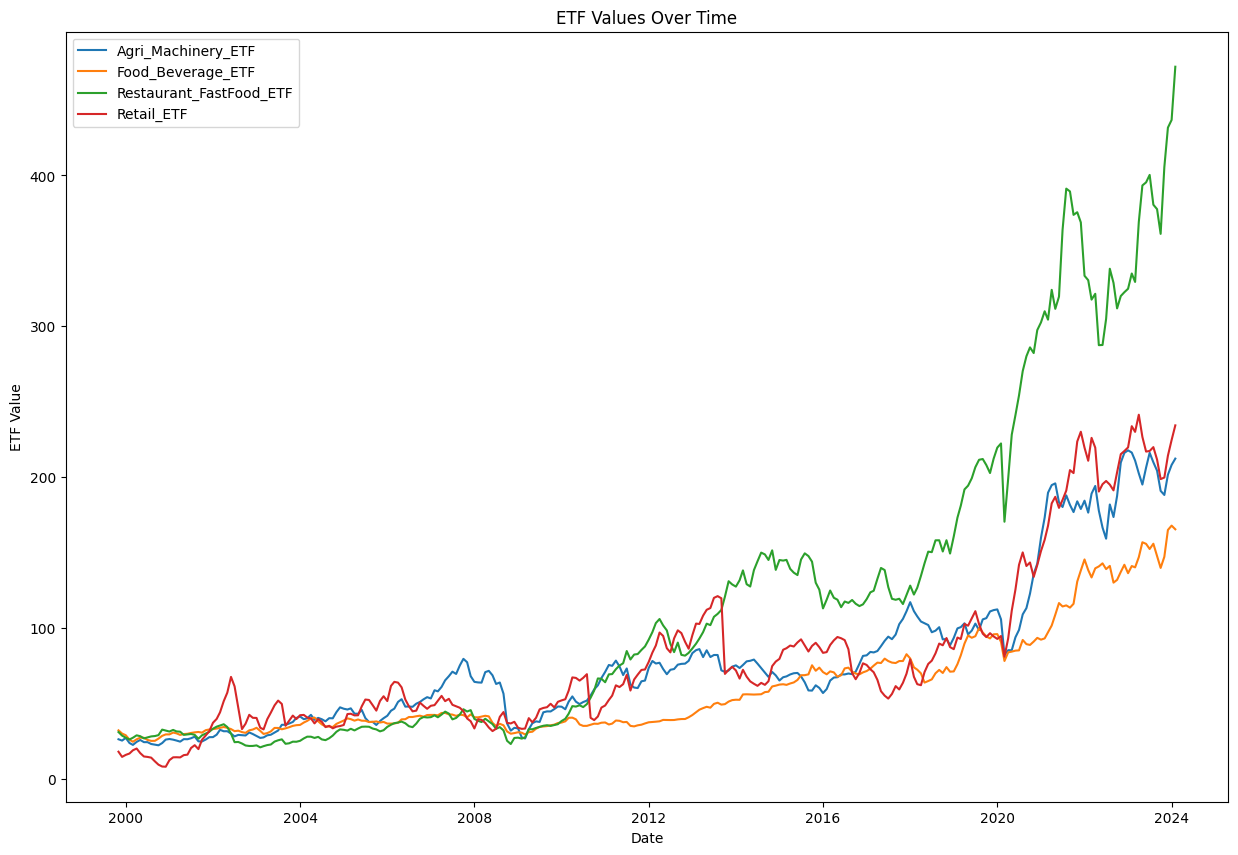

In [29]:
def plot(etf_pivot):
    etf_pivot = etf_pivot.copy()
    etf_pivot['Date'] = pd.to_datetime(etf_pivot[['Year', 'Month']].assign(DAY=1))

    # Set the date column as the index
    etf_pivot.set_index('Date', inplace=True)

    # Select the ETF columns to plot
    etf_columns = ['Agri_Machinery_ETF', 'Food_Beverage_ETF', 'Restaurant_FastFood_ETF', 'Retail_ETF']

    # Plot the ETF values over time
    plt.figure(figsize=(15, 10))
    for etf in etf_columns:
        plt.plot(etf_pivot.index, etf_pivot[etf], label=etf)

    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('ETF Value')
    plt.title('ETF Values Over Time')
    plt.show()
    
plot(etf_prices_pivot)

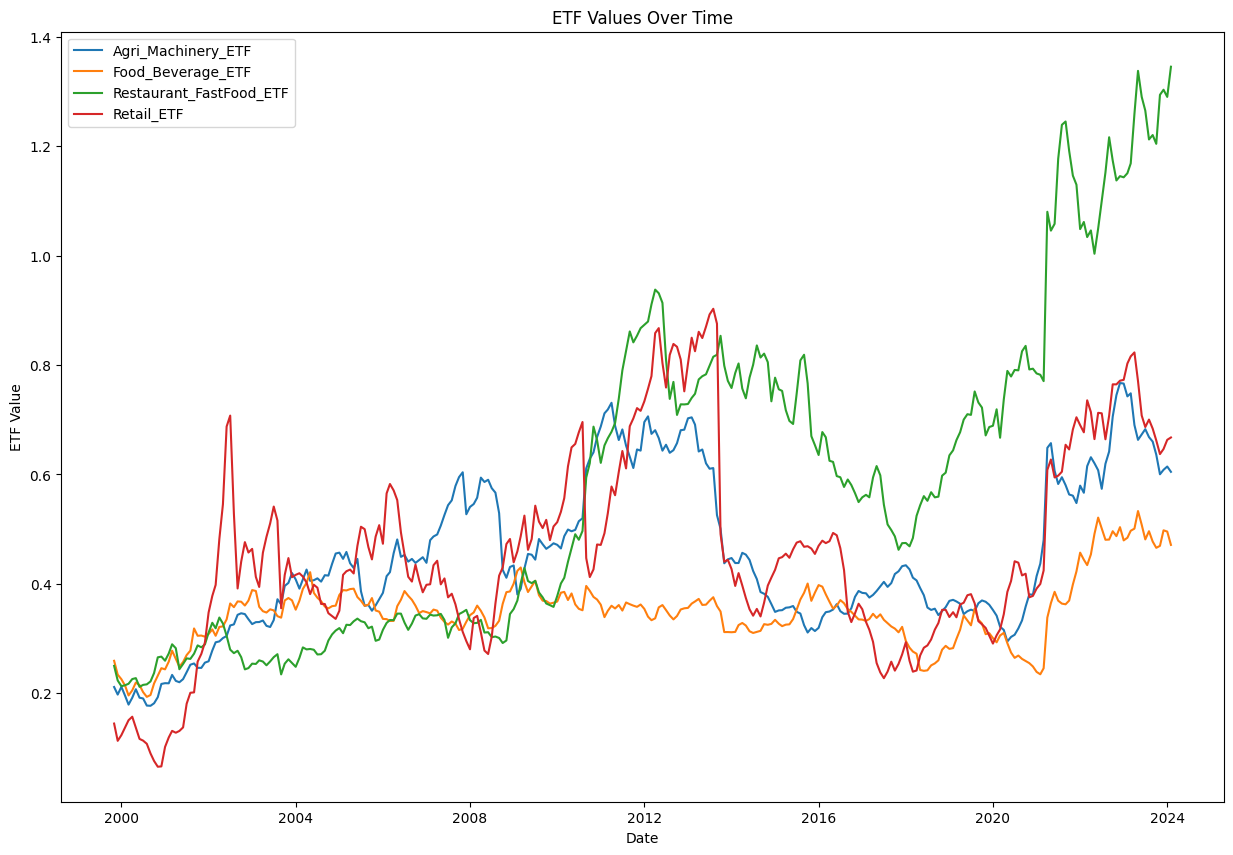

In [30]:
plot(etf_index_norm)

In [32]:
etf_prices_pivot.to_csv('variables_of_interest/averaged_etf_monthly.csv')

In [31]:
etf_index_norm.to_csv('variables_of_interest/index_etf_monthly.csv')

In [8]:
etf_prices.to_csv('variables_of_interest/etf_monthly.csv')

## Generate Yearly ETF Data

In [58]:
yearly_df = etf_prices.groupby(['Year', 'ETF']).agg({'Price': 'mean', 'Volatility': 'mean'}).reset_index()

yearly_df

,Year,ETF,Price,Volatility
0,1999,Agri_Machinery_ETF,35.896562,18.041195
1,1999,Food_Beverage_ETF,38.574624,16.331450
2,1999,Investment_Funds_ETF,127.576142,21.784007
3,1999,Restaurant_FastFood_ETF,33.656642,12.122728
4,1999,Retail_ETF,16.157612,0.000000
...,...,...,...,...
125,2024,Agri_Machinery_ETF,275.591445,132.439912
126,2024,Food_Beverage_ETF,423.274203,272.971293
127,2024,Investment_Funds_ETF,383.809935,194.383929
128,2024,Restaurant_FastFood_ETF,1523.165088,812.518782


In [ ]:
yearly_df.to_csv('variables_of_interest/normalized_etf_yearly.csv')